In [1]:
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import pandas as pd
from os.path import join

from keras.applications.resnet50 import ResNet50

from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from classification import read_generator, IMAGE_HEIGHT, IMAGE_WIDTH, CLASSES_NUM, pad_and_scale
from sklearn.model_selection import train_test_split
from skimage.color import grey2rgb
from tqdm import tqdm_notebook as tqdmn
from skimage.io import imread

Using TensorFlow backend.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pd.read_csv('./public_data/00_input/train/gt.csv')['class_id'].values

array([ 0,  0,  0, ..., 49, 49, 49], dtype=int64)

In [4]:
AS_GREY = False
CHANNELS = 1 if AS_GREY else 3

In [5]:
def read_data(path='./public_data/00_input/train/gt.csv', split=0):
    file = pd.read_csv(path)
    
    if not split:
        return {name:label for name, label in file.values}, {}
    
    x = file['filename'].values.ravel()
    y = file['class_id'].values.ravel()
    files_train, files_test, y_train, y_test = train_test_split(x, y, test_size=split, stratify=y)
    
    return \
        {name:label for name, label in zip(files_train, y_train)}, \
        {name:label for name, label in zip(files_test, y_test)}

train_data, val_data = read_data(split=0.1)

In [6]:
def read_test(y, img_dir='./public_data/00_input/train/images/'):
    test = np.zeros(( len(y), IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
    y_test = np.zeros((len(y), CLASSES_NUM))
    
    for i, img_name in tqdmn(enumerate(y.keys()), total=len(y)):
        img = imread(join(img_dir, img_name), as_grey=AS_GREY)
        
        if len(img.shape) == 2 and not AS_GREY:
            img = grey2rgb(img)
            
        img, _ = pad_and_scale(img)
        y_test[i] = np.zeros(CLASSES_NUM)
         
        test[i, ...] = img.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
        y_test[i][y[img_name]] = 1

    return y_test, test

y_val, x_val = read_test(val_data)

A Jupyter Widget

In [7]:
checkpoint_callback = ModelCheckpoint(filepath = 'checkpoint.hdf5', monitor='val_loss', save_best_only=True, mode='auto')
early_callback = EarlyStopping(patience=15)
lr_callback = ReduceLROnPlateau(patience=5)

In [8]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(CLASSES_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'] )

# train the model on the new data for a few epochs
model.fit_generator(
    read_generator(train_data, './public_data/00_input/train/images', 32, grey=False, permutations=True),  
    steps_per_epoch=len(train_data) // 32, 
    epochs=5,
    callbacks=[checkpoint_callback, early_callback, lr_callback],
    validation_data=(x_val, y_val),
    verbose=1
)

Epoch 1/5
70/70 [==============================] - 248s - loss: 3.9178 - acc: 0.0371 - val_loss: 3.8850 - val_acc: 0.0320
Epoch 2/5
70/70 [==============================] - 224s - loss: 3.8421 - acc: 0.0665 - val_loss: 3.8110 - val_acc: 0.1160
Epoch 3/5
70/70 [==============================] - 223s - loss: 3.7733 - acc: 0.1116 - val_loss: 3.7480 - val_acc: 0.1720
Epoch 4/5
70/70 [==============================] - 224s - loss: 3.6975 - acc: 0.1719 - val_loss: 3.6752 - val_acc: 0.1920
Epoch 5/5
70/70 [==============================] - 222s - loss: 3.6282 - acc: 0.2085 - val_loss: 3.5931 - val_acc: 0.2320


In [ ]:

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [ ]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.


# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit_generator(
    read_generator(train_data, './public_data/00_input/train/images', 32, grey=False,  permutations=True, shuffle=True),  
    steps_per_epoch=len(train_data) // 32, 
    epochs=100,
    callbacks=[checkpoint_callback, early_callback, lr_callback],
    validation_data=(x_val, y_val)
)

Epoch 1/100
22/70 [========>.....................] - ETA: 177s - loss: 3.2119 - acc: 0.2955

In [18]:
gen = read_generator(train_data, './public_data/00_input/train/images', 32, grey=False, permutations=True, shuffle=False)
next(gen)
next(gen)
batch, labels = next(gen)
# model.predict(batch)
batch.shape, labels

((32, 299, 299, 3), array([[ 0.,  1.,  0., ...,  0.,  0.,  0.],
        [ 0.,  1.,  0., ...,  0.,  0.,  0.],
        [ 0.,  1.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  1., ...,  0.,  0.,  0.],
        [ 0.,  0.,  1., ...,  0.,  0.,  0.],
        [ 0.,  0.,  1., ...,  0.,  0.,  0.]]))

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


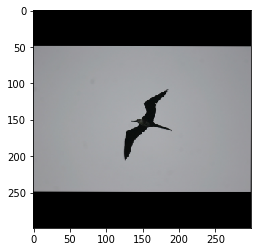

In [49]:
from matplotlib import pyplot as plt

print(labels[21])
plt.imshow(batch[21], cmap='Greys_r')
plt.show()

In [44]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet')

img_path = 'elephant.jpg'
img = image.load_img('./public_data/00_input/train/images/0050.jpg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)


Predicted: [('n02051845', 'pelican', 0.6062426), ('n02058221', 'albatross', 0.34787762), ('n01608432', 'kite', 0.031179607)]


In [ ]:


preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])